In [1]:
import pandas as pd
from google.colab import drive
from tqdm import tqdm

drive.mount('/content/gdrive')
folder_path = "/content/gdrive/My Drive"

Mounted at /content/gdrive


In [2]:
timeseries_df = pd.read_csv(folder_path + "/covid_us_timeseries.csv")
sentiment_df = pd.read_csv(folder_path + "/covid_ts_sentiment_combined.csv")

data = pd.merge(timeseries_df, sentiment_df , on="date", how="inner")
# data = data[timeseries_df.columns]

## Data Visualization

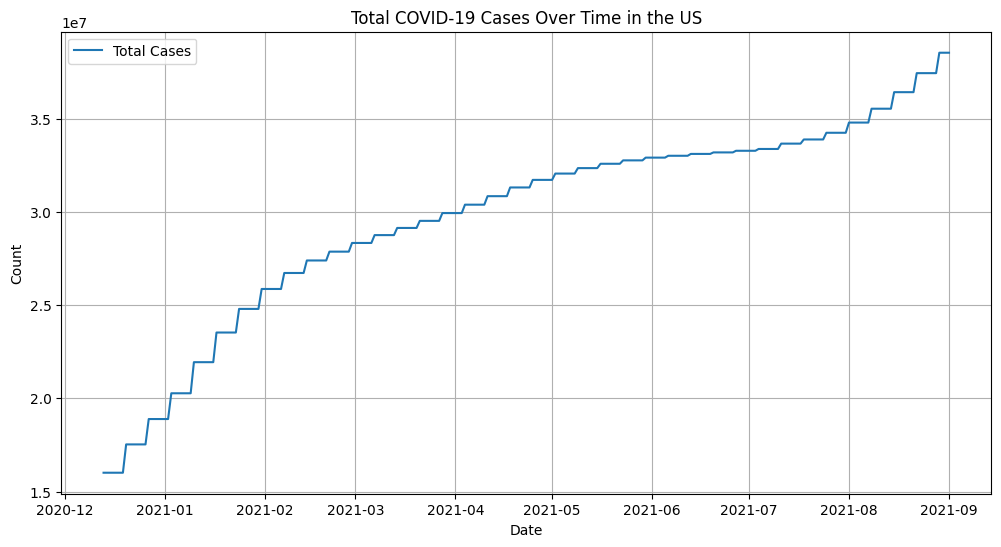

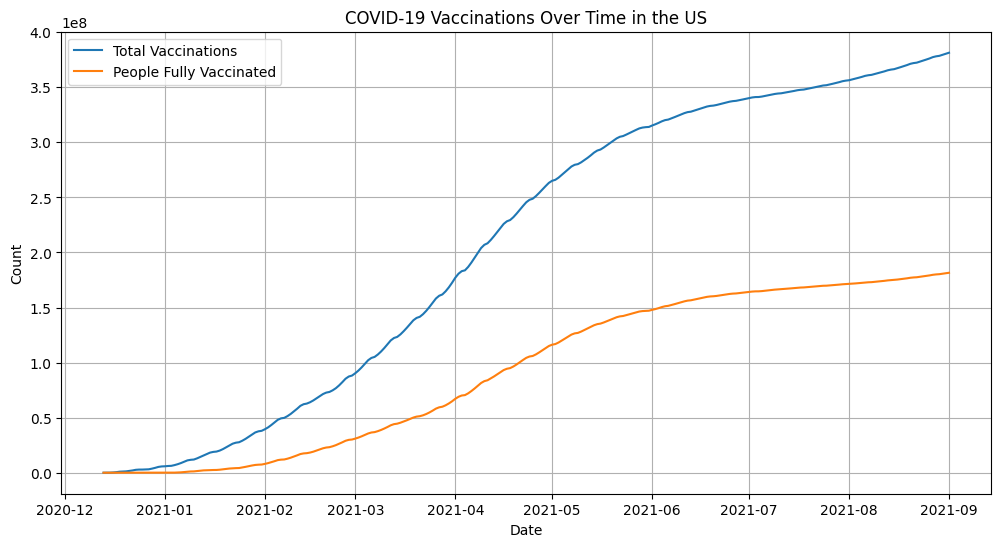

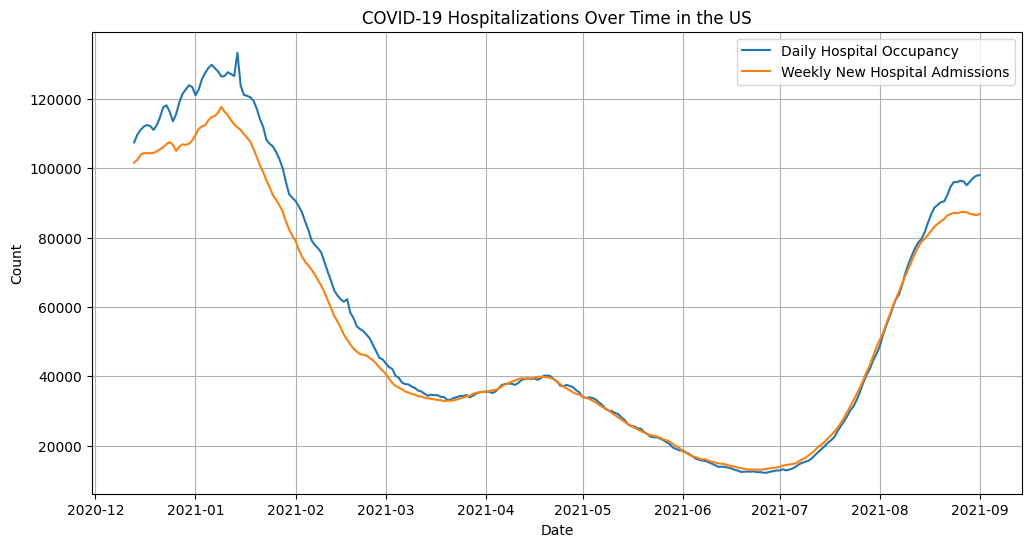

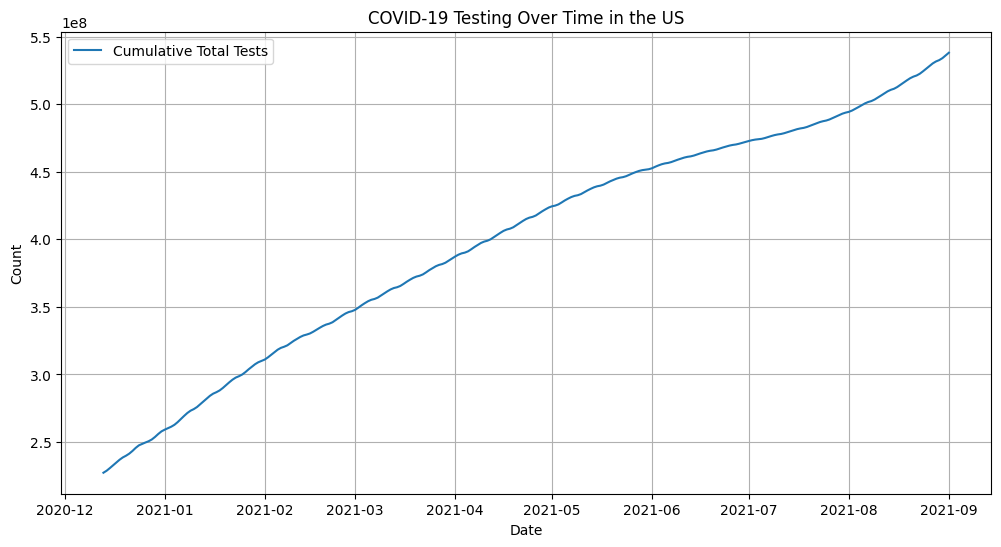

In [3]:
import matplotlib.pyplot as plt

# Convert the 'date' column to datetime objects
data['date'] = pd.to_datetime(data['date'])

# Plotting total cases and total deaths
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['total_cases'], label='Total Cases')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Total COVID-19 Cases Over Time in the US')
plt.legend()
plt.grid(True)
plt.show()

# Plotting total vaccinations and people fully vaccinated
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['total_vaccinations'], label='Total Vaccinations')
plt.plot(data['date'], data['people_fully_vaccinated'], label='People Fully Vaccinated')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('COVID-19 Vaccinations Over Time in the US')
plt.legend()
plt.grid(True)
plt.show()

# Plotting daily hospital occupancy and weekly new hospital admissions
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['Daily hospital occupancy'], label='Daily Hospital Occupancy')
plt.plot(data['date'], data['Weekly new hospital admissions'], label='Weekly New Hospital Admissions')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('COVID-19 Hospitalizations Over Time in the US')
plt.legend()
plt.grid(True)
plt.show()

# Plotting cumulative total tests and 7-day smoothed daily change in tests
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['Cumulative total'], label='Cumulative Total Tests')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('COVID-19 Testing Over Time in the US')
plt.legend()
plt.grid(True)
plt.show()

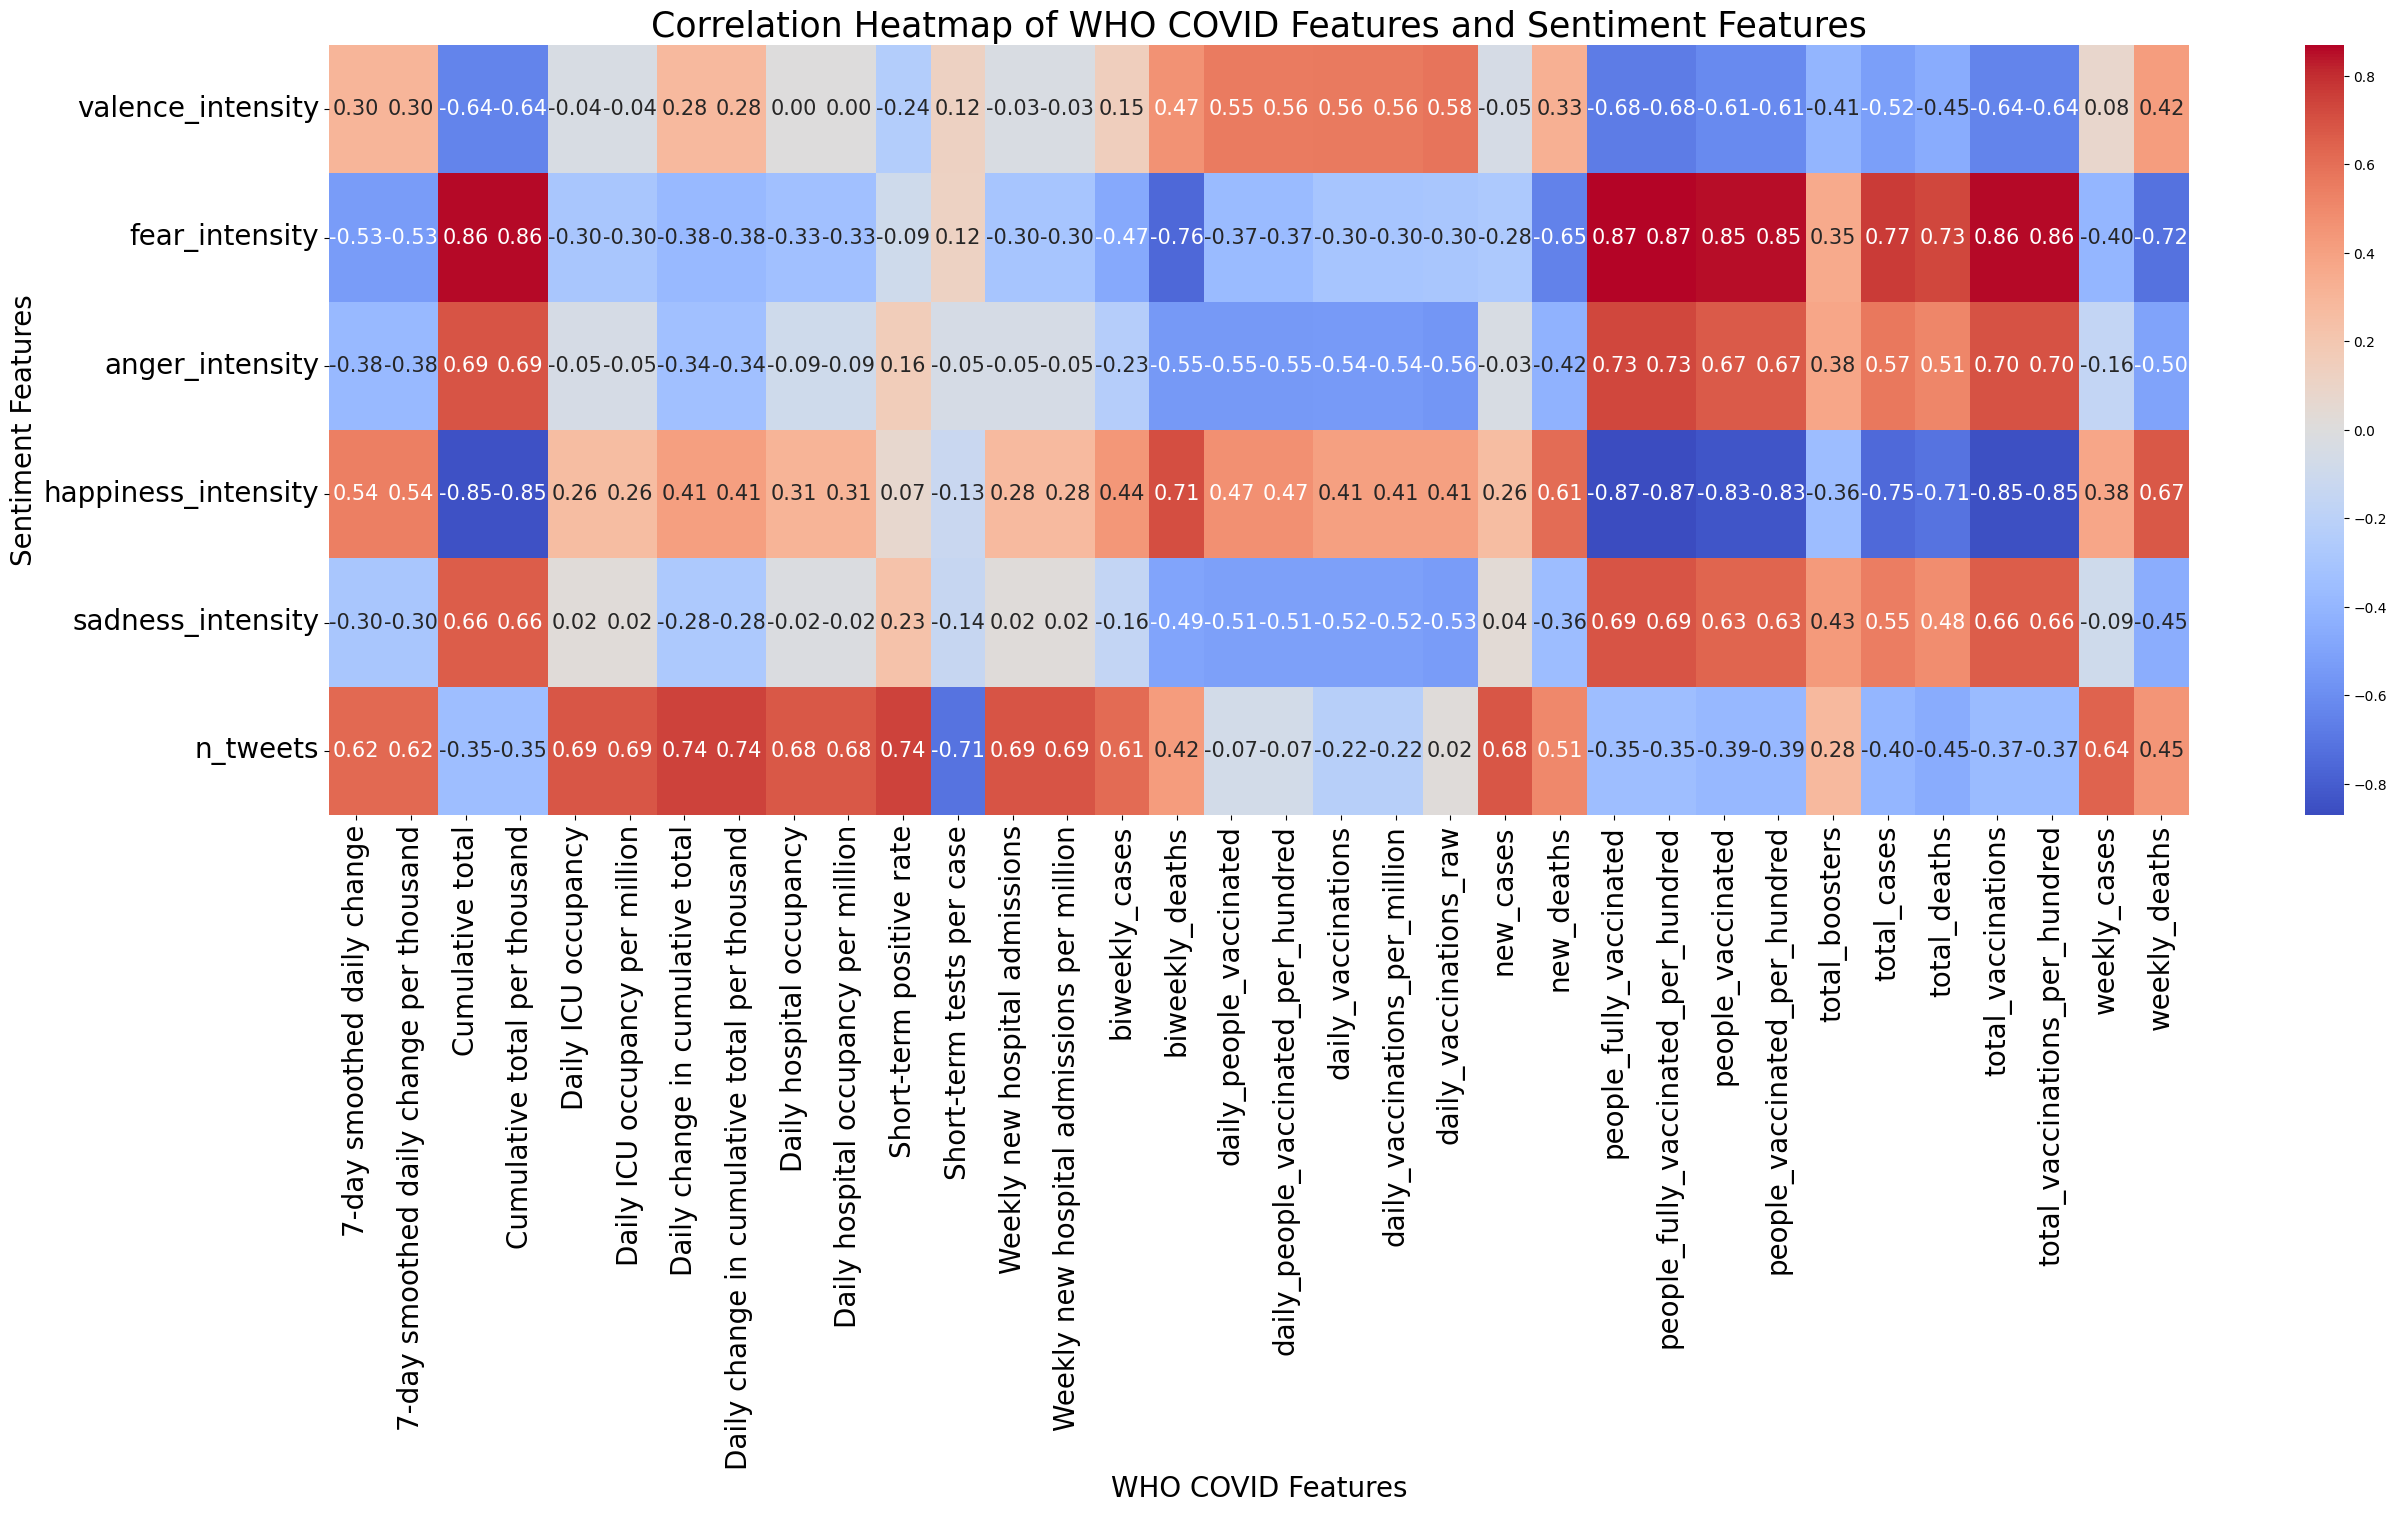

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = data.drop(columns='date').corr()

# Define the subset of features to focus on (sentiment and n_tweets)
subset_features = ['valence_intensity', 'fear_intensity', 'anger_intensity', 'happiness_intensity', 'sadness_intensity', 'n_tweets']

# Define the features to exclude (the same sentiment and n_tweets features)
exclude_features = subset_features

# Filter the correlation matrix to show correlations of the subset features with all other features *except* the excluded features
# Select rows for subset_features and columns by dropping excluded_features
filtered_correlation_matrix = correlation_matrix.loc[subset_features, correlation_matrix.columns.difference(exclude_features)]

# Plot the heatmap
plt.figure(figsize=(30, 10)) # Adjusted figure size for better readability
ax = sns.heatmap(filtered_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 15}) # annot=True to show values, adjust annot_kws for font size
plt.title('Correlation Heatmap of WHO COVID Features and Sentiment Features', fontsize=25)
plt.xlabel('WHO COVID Features', fontsize=20) # Increase x-label font size
plt.ylabel('Sentiment Features', fontsize=20) # Increase y-label font size
ax.tick_params(axis='both', which='major', labelsize=20) # Increase tick label font size
plt.show()

## Prepare for Training

### Data Preprocessing for Training

In [64]:
target_feature = 'biweekly_deaths'

In [65]:
# Check for missing values in the specified columns in the training DataFrame
missing_values = data[['total_boosters', 'daily_vaccinations_raw', 'daily_vaccinations', 'daily_vaccinations_per_million', 'daily_people_vaccinated', 'daily_people_vaccinated_per_hundred']].isnull().sum()

print("Missing values in training data:")
print(missing_values)

# Impute missing values in train_df
data['total_boosters'] = data['total_boosters'].fillna(0)
columns_to_impute = ['daily_vaccinations_raw', 'daily_vaccinations', 'daily_vaccinations_per_million', 'daily_people_vaccinated', 'daily_people_vaccinated_per_hundred']
for col in columns_to_impute:
    data[col] = data[col].fillna(method='ffill').fillna(method='bfill')

Missing values in training data:
total_boosters                         0
daily_vaccinations_raw                 0
daily_vaccinations                     0
daily_vaccinations_per_million         0
daily_people_vaccinated                0
daily_people_vaccinated_per_hundred    0
dtype: int64


/tmp/ipython-input-3978570399.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[col] = data[col].fillna(method='ffill').fillna(method='bfill')


In [66]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Sort data by date for time-based split
data_sorted = data.sort_values('date').copy()

# Perform time-based split
split_index = int(len(data_sorted) * 0.8)

train_data = data_sorted.iloc[:split_index].copy()
test_data = data_sorted.iloc[split_index:].copy()

# Define target variable 'y' and features for training and testing sets
train_df = train_data.drop(columns=['date'])
test_df = test_data.drop(columns=['date'])

train_df = train_df.rename(columns={target_feature: 'y'})
test_df = test_df.rename(columns={target_feature: 'y'})


# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the numerical features of the training data
scaled_train = scaler.fit_transform(train_df)
train_df = pd.DataFrame(scaled_train, columns=train_df.columns, index=train_df.index)

# Transform the numerical features of the testing data using the scaler fitted on training data
scaled_test = scaler.transform(test_df)
test_df = pd.DataFrame(scaled_test, columns=test_df.columns, index=test_df.index)


# # Combine scaled numerical features, 'ds', 'y', and 'unique_id' for train_df
# train_df = train_df[['ds', 'y']].copy() # Start with ds and y
# train_df = pd.concat([train_df, scaled_train_df], axis=1)
# train_df['unique_id'] = 1

# # Combine scaled numerical features, 'ds', 'y', and 'unique_id' for test_df
# test_df = test_df[['ds', 'y']].copy() # Start with ds and y
# test_df = pd.concat([test_df, scaled_test_df], axis=1)
# test_df['unique_id'] = 1

# Impute missing values in train_df
train_df['total_boosters'] = train_df['total_boosters'].fillna(0)
columns_to_impute = ['daily_vaccinations_raw', 'daily_vaccinations', 'daily_vaccinations_per_million', 'daily_people_vaccinated', 'daily_people_vaccinated_per_hundred']
for col in columns_to_impute:
    train_df[col] = train_df[col].fillna(method='ffill').fillna(method='bfill')

# Impute missing values in test_df
test_df['total_boosters'] = test_df['total_boosters'].fillna(0)
for col in columns_to_impute:
    test_df[col] = test_df[col].fillna(method='ffill').fillna(method='bfill')


print("Training DataFrame shape:", train_df.shape)
print("Testing DataFrame shape:", test_df.shape)

# Check missing values after imputation in training data
print("\nMissing values in training data after imputation:")
print(train_df[columns_to_impute + ['total_boosters']].isnull().sum())

# Check missing values after imputation in testing data
print("\nMissing values in testing data after imputation:")
print(test_df[columns_to_impute + ['total_boosters']].isnull().sum())


Training DataFrame shape: (210, 40)
Testing DataFrame shape: (53, 40)

Missing values in training data after imputation:
daily_vaccinations_raw                 0
daily_vaccinations                     0
daily_vaccinations_per_million         0
daily_people_vaccinated                0
daily_people_vaccinated_per_hundred    0
total_boosters                         0
dtype: int64

Missing values in testing data after imputation:
daily_vaccinations_raw                 0
daily_vaccinations                     0
daily_vaccinations_per_million         0
daily_people_vaccinated                0
daily_people_vaccinated_per_hundred    0
total_boosters                         0
dtype: int64


/tmp/ipython-input-2119525742.py:48: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_df[col] = train_df[col].fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-2119525742.py:53: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_df[col] = test_df[col].fillna(method='ffill').fillna(method='bfill')


Epoch 1/50 - train: 1.0244  test: 0.1241
Epoch 2/50 - train: 0.9438  test: 0.0957
Epoch 3/50 - train: 0.8659  test: 0.0754
Epoch 4/50 - train: 0.7920  test: 0.0623
Epoch 5/50 - train: 0.7154  test: 0.0564
Epoch 6/50 - train: 0.6385  test: 0.0567
Epoch 7/50 - train: 0.5582  test: 0.0621
Epoch 8/50 - train: 0.4754  test: 0.0714
Epoch 9/50 - train: 0.3999  test: 0.0839
Epoch 10/50 - train: 0.3273  test: 0.0976
Epoch 11/50 - train: 0.2709  test: 0.1101
Epoch 12/50 - train: 0.2245  test: 0.1226
Epoch 13/50 - train: 0.1924  test: 0.1364
Epoch 14/50 - train: 0.1694  test: 0.1475
Epoch 15/50 - train: 0.1537  test: 0.1590
Epoch 16/50 - train: 0.1400  test: 0.1691
Epoch 17/50 - train: 0.1286  test: 0.1795
Epoch 18/50 - train: 0.1196  test: 0.1885
Epoch 19/50 - train: 0.1087  test: 0.1925
Epoch 20/50 - train: 0.0978  test: 0.1930
Epoch 21/50 - train: 0.0879  test: 0.1945
Epoch 22/50 - train: 0.0784  test: 0.1991
Epoch 23/50 - train: 0.0679  test: 0.1991
Epoch 24/50 - train: 0.0583  test: 0.2008
E

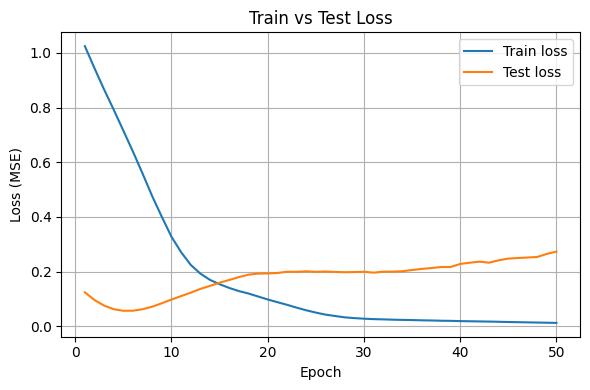

In [69]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error # Import mean_squared_error

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class LSTMForecaster(nn.Module):
    def __init__(self, n_features, hidden_size=8, num_layers=1, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: (batch, lookback, n_features)
        out, _ = self.lstm(x)        # (batch, lookback, hidden)
        last_hidden = out[:, -1, :]  # (batch, hidden)
        y_hat = self.fc(last_hidden) # (batch, 1)
        return y_hat


lookback = 30  # window size

def build_sequences(df, lookback, target_col='y'):
    # feature_cols = ['y', 'valence_intensity', 'fear_intensity', 'anger_intensity', 'happiness_intensity', 'sadness_intensity']
    feature_cols = ['y', 'fear_intensity']
    # feature_cols = ['y']
    values = df[feature_cols].values.astype('float32')
    target_idx = feature_cols.index(target_col)

    X, y = [], []
    for t in range(len(values) - lookback):
        X.append(values[t:t+lookback, :])            # (lookback, n_features)
        y.append(values[t+lookback, target_idx])     # scalar target

    X = np.array(X)                      # (N, lookback, n_features)
    y = np.array(y).reshape(-1, 1)       # (N, 1)
    return X, y, len(feature_cols)

X_train, y_train, n_features = build_sequences(train_df, lookback)
X_test,  y_test, _           = build_sequences(test_df,  lookback)

X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_test  = torch.from_numpy(X_test)
y_test  = torch.from_numpy(y_test)

train_ds = TimeSeriesDataset(X_train, y_train)
test_ds  = TimeSeriesDataset(X_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=16, shuffle=False)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTMForecaster(n_features=n_features, hidden_size=8, num_layers=1, dropout=0.3).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-3, lr=0.001)

# =========================
# Training loop
# =========================
epochs = 50

train_losses = []
test_losses = []

for epoch in range(epochs):
    # -------- train --------
    model.train()
    train_loss = 0.0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # -------- test (val) --------
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            test_loss += loss.item() * xb.size(0)

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print(f"Epoch {epoch+1}/{epochs} - train: {train_loss:.4f}  test: {test_loss:.4f}")



y_true_list, y_pred_list = [], []
model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        preds = model(xb)
        y_true_list.append(yb.cpu().numpy())
        y_pred_list.append(preds.cpu().numpy())

y_true = np.vstack(y_true_list).ravel()
y_pred = np.vstack(y_pred_list).ravel()

mse_total_cases = mean_squared_error(y_true, y_pred)

print(f"\nFinal Test MSE for {target_feature} (y): {min(test_losses):.4f}")

# -------- plot loss curves to inspect overfitting --------
plt.figure(figsize=(6,4))
plt.plot(range(1, epochs+1), train_losses, label='Train loss')
plt.plot(range(1, epochs+1), test_losses, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Train vs Test Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Chronos-2

In [ ]:
!pip install "chronos-forecasting>=2.0"

In [ ]:
from chronos import Chronos2Pipeline

pipeline = Chronos2Pipeline.from_pretrained("amazon/chronos-2", device_map="cuda")

# Load historical target values and past values of covariates
context_df = pd.read_parquet("https://autogluon.s3.amazonaws.com/datasets/timeseries/electricity_price/train.parquet")

# (Optional) Load future values of covariates
test_df = pd.read_parquet("https://autogluon.s3.amazonaws.com/datasets/timeseries/electricity_price/test.parquet")
future_df = test_df.drop(columns="target")

# Generate predictions with covariates
pred_df = pipeline.predict_df(
    context_df,
    future_df=future_df,
    prediction_length=24,  # Number of steps to forecast
    quantile_levels=[0.1, 0.5, 0.9],  # Quantiles for probabilistic forecast
    id_column="id",  # Column identifying different time series
    timestamp_column="timestamp",  # Column with datetime information
    target="target",  # Column(s) with time series values to predict
)


In [ ]:
ts_context = context_df.set_index("timestamp")["target"].tail(256)
ts_pred = pred_df.set_index("timestamp")
ts_ground_truth = test_df.set_index("timestamp")["target"]

ts_context.plot(label="historical data", color="xkcd:azure", figsize=(12, 3))
ts_ground_truth.plot(label="future data (ground truth)", color="xkcd:grass green")
ts_pred["predictions"].plot(label="forecast", color="xkcd:violet")
plt.fill_between(
    ts_pred.index,
    ts_pred["0.1"],
    ts_pred["0.9"],
    alpha=0.7,
    label="prediction interval",
    color="xkcd:light lavender",
)
plt.legend()